In [2]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.transforms as mtrans

In [3]:
#reformat dictionnaries into dataframes for seaborn

def reformat(dict_plot, xlabel):

        df = pd.DataFrame({xlabel: [], 'AUC': []})
        for model, list_values in dict_plot.items():
            for value in list_values:
                new_row = {xlabel: model, 'AUC': value}
                df = df.append(new_row, ignore_index=True)
        
        return df

In [16]:
#plot all models (require to merge the group the dataframes in a dictionnary)

def plot_models_perf(dict_to_plot,
                    save_dir,
                    title,
                    xlabel,
                    legend_title='',
                    save_fig=True,
                    normalize=True):

    #erase previous plot
    plt.close()

    #legend
    patches=[]
    for name, (_, color) in dict_to_plot.items():
        patch = mpatches.Patch(color=color, label=name)
        patches.append(patch)

    #plot
    fig,ax = plt.subplots(figsize=(8,6))

    for idx, (name, (df, color)) in enumerate(dict_to_plot.items()):
        #tr = offset_plot(idx*3, fig=fig)
        sns.pointplot(data=df[::2], x=xlabel, y='AUC', color=color, markers='s', linestyles='', ax=ax).set(title=title)
        sns.stripplot(data=df[::2], x=xlabel, y='AUC', color=color, marker='v', ax=ax)
        sns.pointplot(data=df[1::2], x=xlabel, y='AUC', color='green', markers='s', ax=ax)

    #offset the distributions for a same model
    nb_test_sets = len(dict_to_plot.keys())
    for idx in range(nb_test_sets):
        offset = mtrans.ScaledTranslation(0.1*idx, 0, ax.figure.dpi_scale_trans)
        nb_coll = len(ax.collections)
        start_offset_idx, end_offset_idx = idx*nb_coll // nb_test_sets, (idx+1)*nb_coll // nb_test_sets
        for k in range(start_offset_idx, end_offset_idx): #don't really understand the collection organization
            #first offset the points
            trans = ax.collections[k].get_transform()
            ax.collections[k].set_transform(trans + offset)
            #offset the errorbars
            trans = ax.lines[k].get_transform()
            ax.lines[k].set_transform(trans + offset)
    if normalize:
        ax.set_ylim([0.45, 1])
    plt.legend(handles=patches, title=legend_title)
    plt.xticks(rotation=5)
    if save_fig:
        plt.savefig(save_dir, facecolor='white')
    
    plt.show()

In [17]:
# look for AUC values in outputs
dir = '/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/'
model_dict = {'UKB SimCLR': '2023-06-15/14-36-49/',
              'morpho positional': 'morpho/morpho_positional/',
              'morpho shape': 'morpho/morpho_shape/',
              'morpho all': 'morpho/morpho_all/'}
dict_plot_preterm = {}
for label in [28, 32, 37]:
    dict_plot = {}
    for model, model_dir in model_dict.items():
        with open(dir+model_dir+f'STs_dHCP_374_subjects_embeddings/Preterm_{label}/values.json') as f:
            values = json.load(f)
        auc = values['cross_val_auc'][0]
        perm_95 = values['cross_val_permutations'][3]
        ########
        # TRY TO SHOW SECOND VALUE IN LIST DIFFERENTLY IN PLOT ...
        ########
        dict_plot[model]=[auc, perm_95]
    dict_plot_preterm[f'Preterm_{label}']=dict_plot

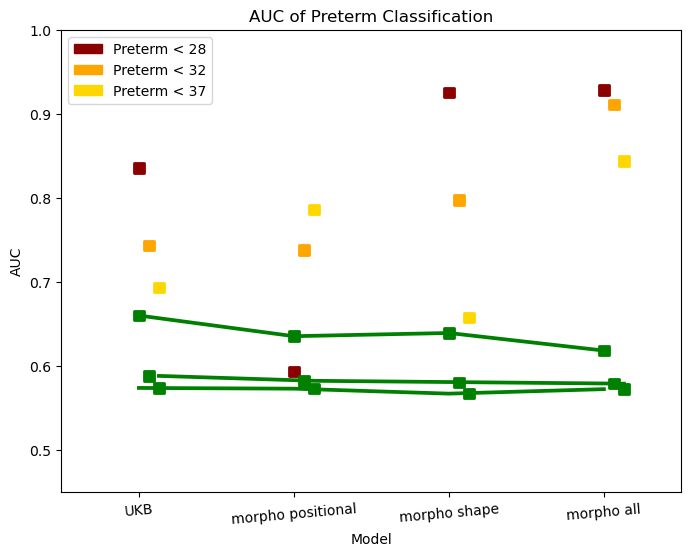

In [19]:
xlabel='Model'
title='AUC of Preterm Classification'
save_dir = '/home/jl274628/Images/AUCs_Preterm_UKB_morpho.png'

####
df_28 = reformat(dict_plot_preterm['Preterm_28'], xlabel)
df_32 = reformat(dict_plot_preterm['Preterm_32'], xlabel)
df_37 = reformat(dict_plot_preterm['Preterm_37'], xlabel)

dict_to_plot = {"Preterm < 28": [df_28, 'darkred'],
                "Preterm < 32": [df_32, 'orange'],
                "Preterm < 37": [df_37, 'gold']}

#plot and save model
plot_models_perf(dict_to_plot,
                 save_dir,
                 title,
                 xlabel,
                 save_fig=False)

In [67]:
labels = [28, 32, 37]

dir = '/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/'
model_dict = {'UKB SimCLR': '2023-06-15/14-36-49/',
              'morpho positional': 'morpho/morpho_positional/',
              'morpho shape': 'morpho/morpho_shape/',
              'morpho all': 'morpho/morpho_all/'}

dict_to_plot = {'UKB SimCLR': {},
                'morpho positional': {},
                'morpho shape': {},
                'morpho all': {}}

for model, model_dir in model_dict.items():
    for label in labels:
        with open(dir+model_dir+f'STs_dHCP_374_subjects_embeddings/Preterm_{label}/values.json') as f:
            values = json.load(f)
        auc = values['cross_val_auc'][0]
        perm_95 = values['cross_val_permutations'][3]
        dict_to_plot[model][f'{label}'] = (auc, perm_95)

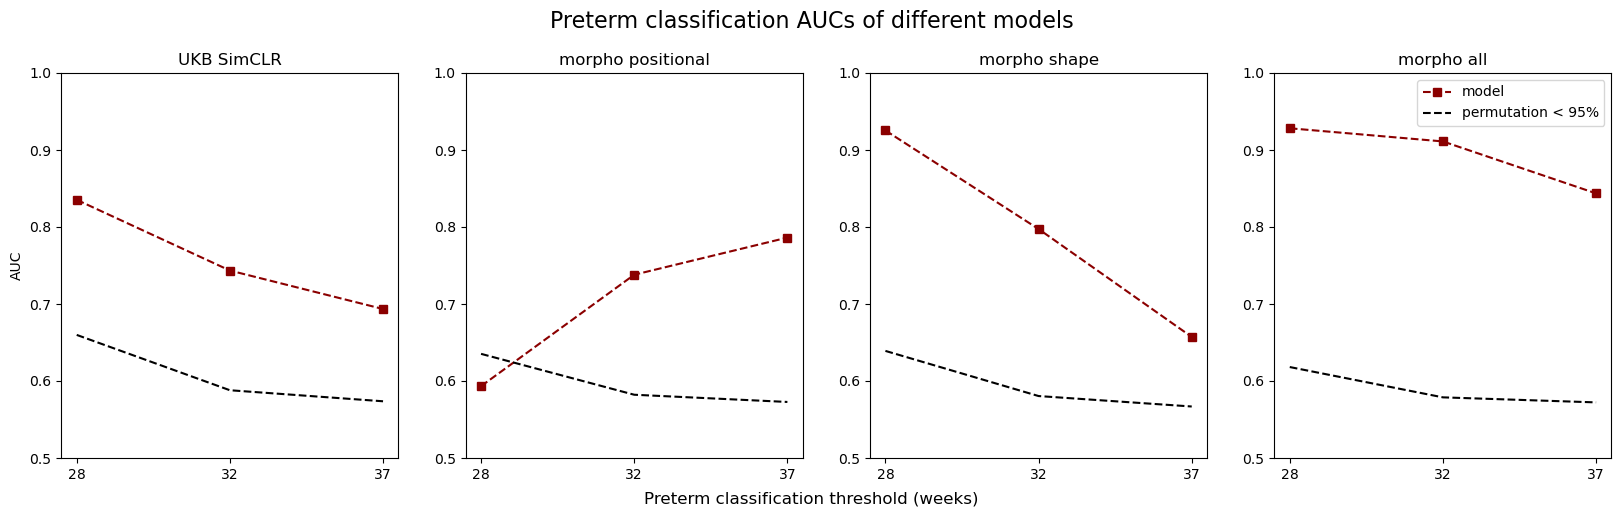

In [69]:
save_dir = '/home/jl274628/Documents/PLOT_RAPPORT/AUC/'

plt.close()
fig, axs = plt.subplots(ncols=len(dict_to_plot), figsize=(5*len(dict_to_plot), 5))
for idx, (model, dict_perf) in enumerate(dict_to_plot.items()):
    ax=axs[idx]
    x=dict_perf.keys()
    y=dict_perf.values()
    ax.plot(x, [a[0] for a in y], c='darkred', marker='s', linestyle='--', label='model')
    ax.plot(x, [a[1] for a in y], c='black', linestyle='--', label='permutation < 95%')
    ax.set_title(model)
    ax.set_ylim((0.5,1))
plt.text(x=0.5, y=0.97, s="Preterm classification AUCs of different models", ha="center", transform=fig.transFigure, fontsize=16)
plt.text(x=0.5, y=0.02, s="Preterm classification threshold (weeks)", ha="center", transform=fig.transFigure, fontsize=12)
axs[0].set_ylabel('AUC')
plt.legend()
plt.savefig(save_dir+f'AUCs_Preterm_UKB_morpho.png')
plt.show()

In [70]:
dir = '/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/'
model_dict = {'UKB SimCLR': '2023-06-15/14-36-49/',
              'dHCP SimCLR': 'dHCP/17-02-23_1/',
              'UKB + dHCP SimCLR': '2023-06-16/11-54-27/'}

dict_to_plot = {'UKB SimCLR': {},
                'dHCP SimCLR': {},
                'UKB + dHCP SimCLR': {}}

for model, model_dir in model_dict.items():
    for label in labels:
        with open(dir+model_dir+f'STs_dHCP_374_subjects_embeddings/Preterm_{label}/values.json') as f:
            values = json.load(f)
        auc = values['cross_val_auc'][0]
        perm_95 = values['cross_val_permutations'][3]
        dict_to_plot[model][f'{label}'] = (auc, perm_95)

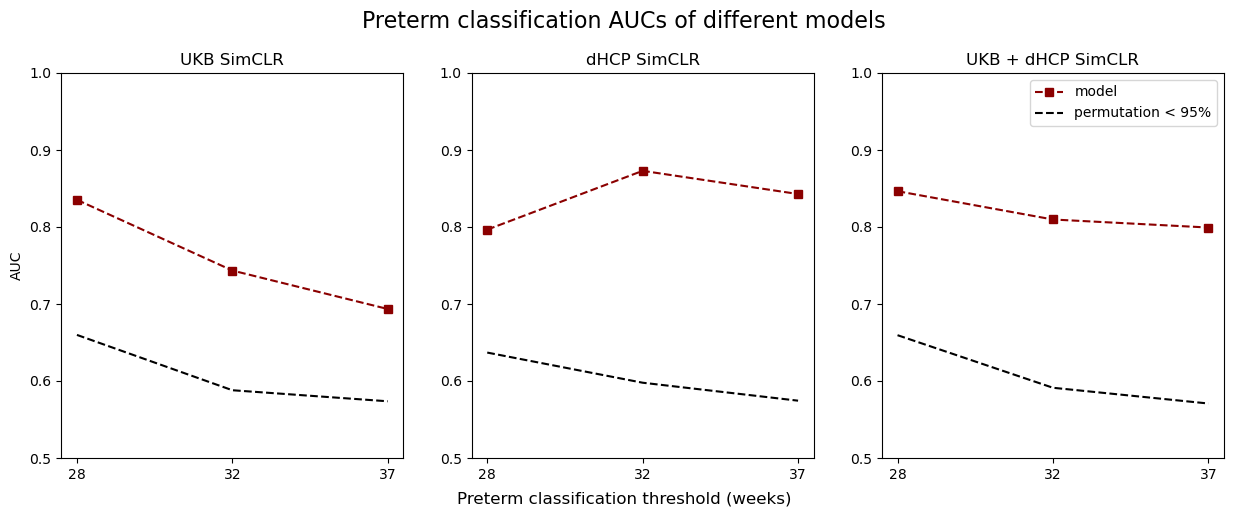

In [71]:
save_dir = '/home/jl274628/Documents/PLOT_RAPPORT/AUC/'

plt.close()
fig, axs = plt.subplots(ncols=len(dict_to_plot), figsize=(5*len(dict_to_plot), 5))
for idx, (model, dict_perf) in enumerate(dict_to_plot.items()):
    ax=axs[idx]
    x=dict_perf.keys()
    y=dict_perf.values()
    ax.plot(x, [a[0] for a in y], c='darkred', marker='s', linestyle='--', label='model')
    ax.plot(x, [a[1] for a in y], c='black', linestyle='--', label='permutation < 95%')
    ax.set_title(model)
    ax.set_ylim((0.5,1))
plt.text(x=0.5, y=0.97, s="Preterm classification AUCs of different models", ha="center", transform=fig.transFigure, fontsize=16)
plt.text(x=0.5, y=0.02, s="Preterm classification threshold (weeks)", ha="center", transform=fig.transFigure, fontsize=12)
axs[0].set_ylabel('AUC')
plt.legend()
plt.savefig(save_dir+f'AUCs_Preterm_SimCLR.png')
plt.show()

In [ ]:
# same plot but comparing UKB, dHCP and dHCP pretrain
# the negative slope of UKB compared to dHCP seems more natural: better generalization. Maybe dHCP fails at 28 because it has not seen enough preterm. It shows that it sticks to its data.